### Описание задания

Построить модель ARIMA для временного ряда.

Дополнительно: спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import boxcox
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

import warnings
warnings.simplefilter('ignore')

Из прошлого проекта [Introducing_in_time_series](../1_Introducing_in_time_series/introducing_in_time_series.ipynb) один не стационарный временной ряд "Mean monthly air temperature (Deg. F) Nottingham Castle" с сезонностью.

In [2]:
mean_monthly_temp = pd.read_csv('../Data/mean-monthly-air-temperature-deg.csv')["Deg"]

### Необходимые функции

In [3]:
def test_stationarity(timeseries):
    """Dickey-Fuller Test"""
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    """Make original, autocorrelation(ACR) and partial autocorrelation(PACF) plots"""
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    plt.show()
    return

### Исследование временного ряда

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


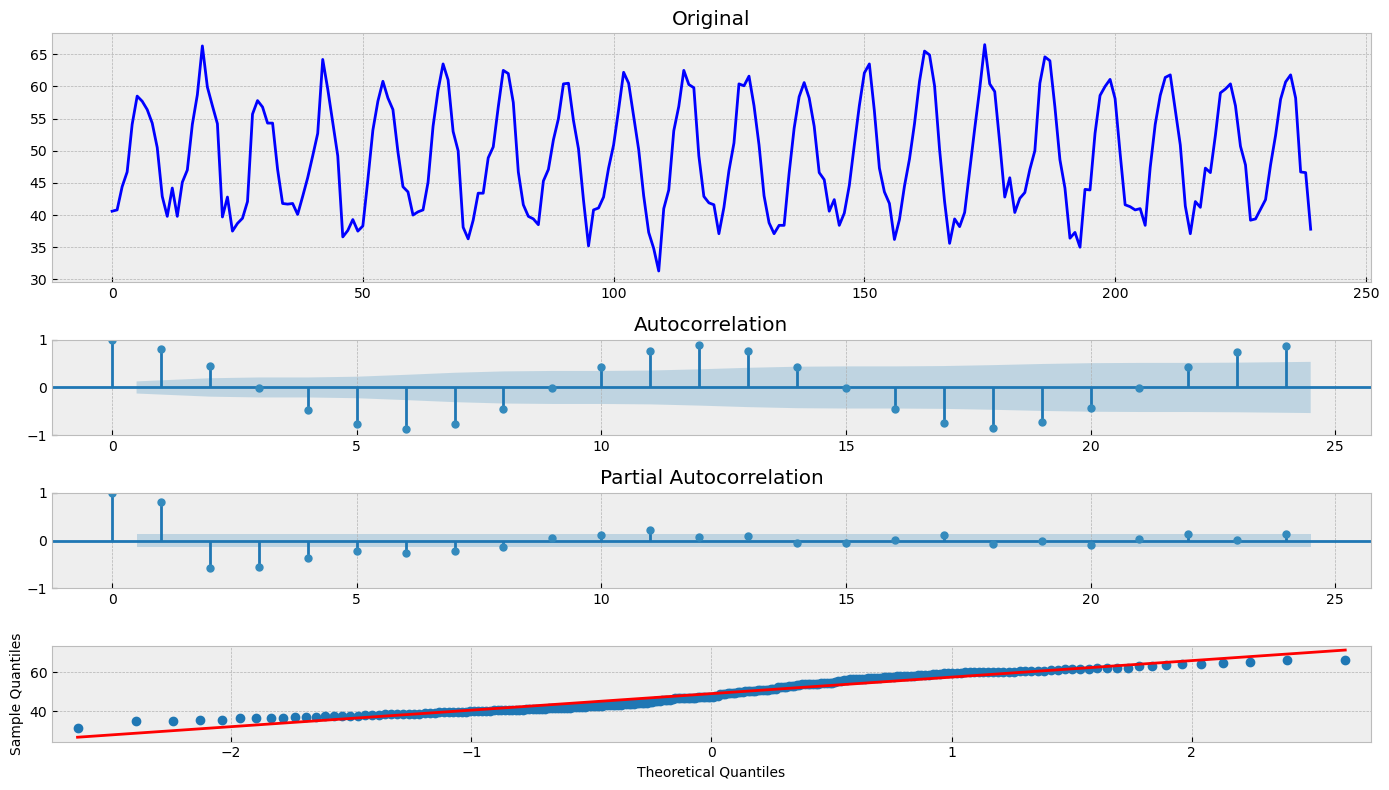

In [4]:
tsplot(mean_monthly_temp)

Визуально наблюдаем наличие сезонности в данны, при этом Тест Дики-Фуллера отвергает гипотезу о нестационарности ряда. 

### Обучение модели ARIMA 
Подберём оптимальные параметры модели, основываясь на наименьшем критерии AIC

aic: 1135.99155 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -5.687367e+00
p-value                        8.220238e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


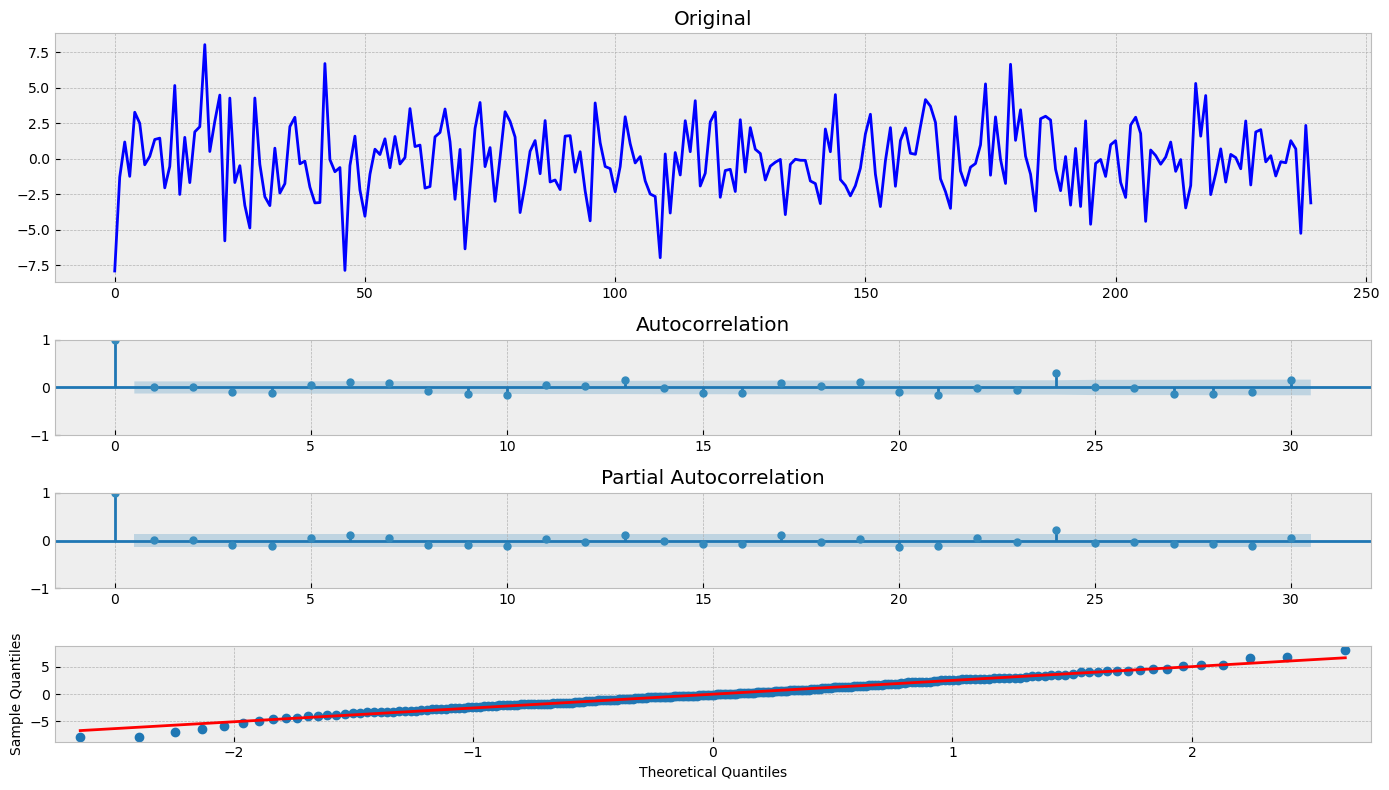

In [5]:
best_aic = np.inf 
best_order = None
best_mdl = None

for fst in range(5):
    for snd in range(5):
        for trd in range(5):
            try:
                tmp_mdl = ARIMA(mean_monthly_temp,order=(fst, snd, trd), trend='ct').fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (fst, snd, trd)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

In [6]:
print(best_mdl.summary())

                               SARIMAX Results                                
Dep. Variable:                    Deg   No. Observations:                  240
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -559.996
Date:                Mon, 05 Jun 2023   AIC                           1135.992
Time:                        12:52:39   BIC                           1163.837
Sample:                             0   HQIC                          1147.211
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.4976      0.384    126.304      0.000      47.745      49.250
x1             0.0044      0.003      1.441      0.150      -0.002       0.010
ar.L1          2.0071      0.072     27.717      0.0

Проверим, что остатки у нас являются статическим временным рядом.

Results of Dickey-Fuller Test:
Test Statistic                -5.687367e+00
p-value                        8.220238e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


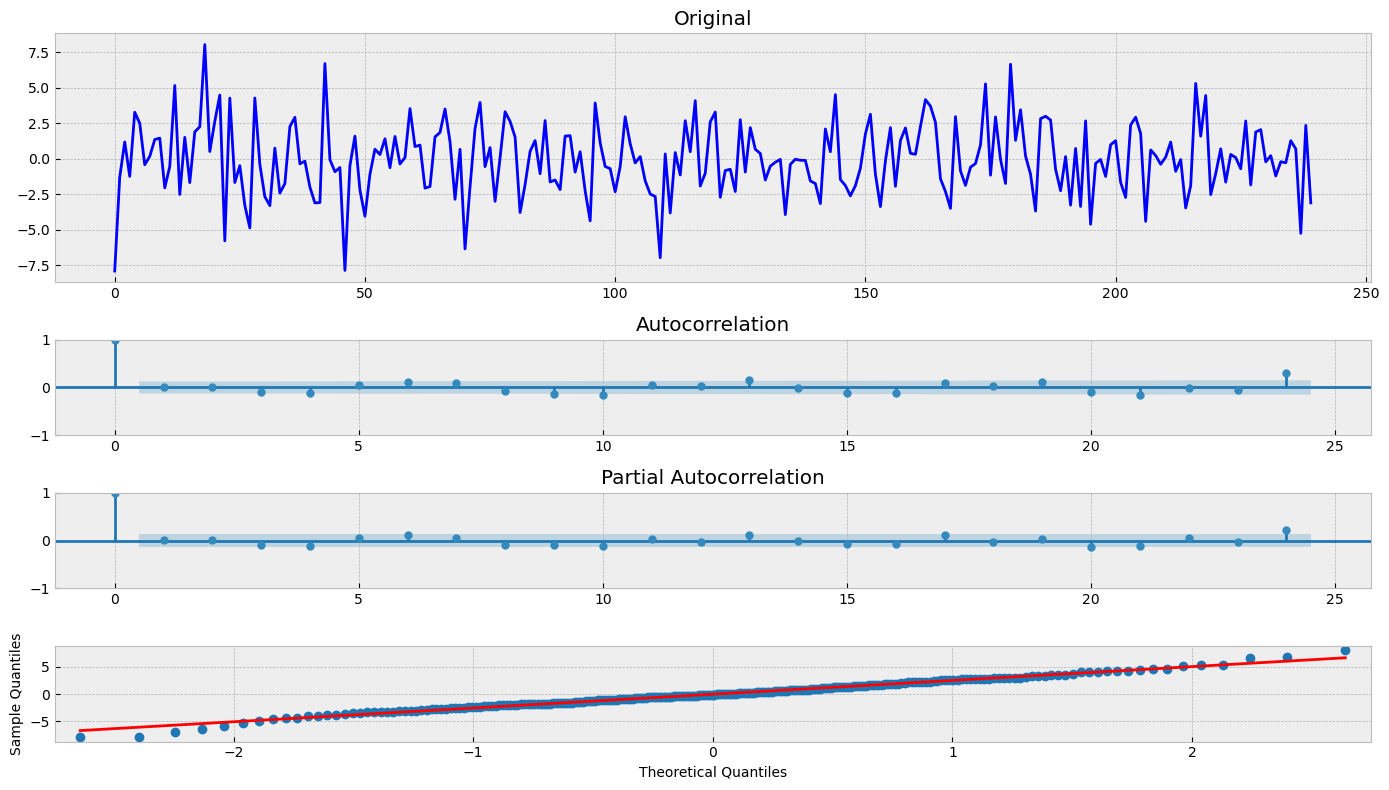

In [7]:
tsplot(best_mdl.resid)

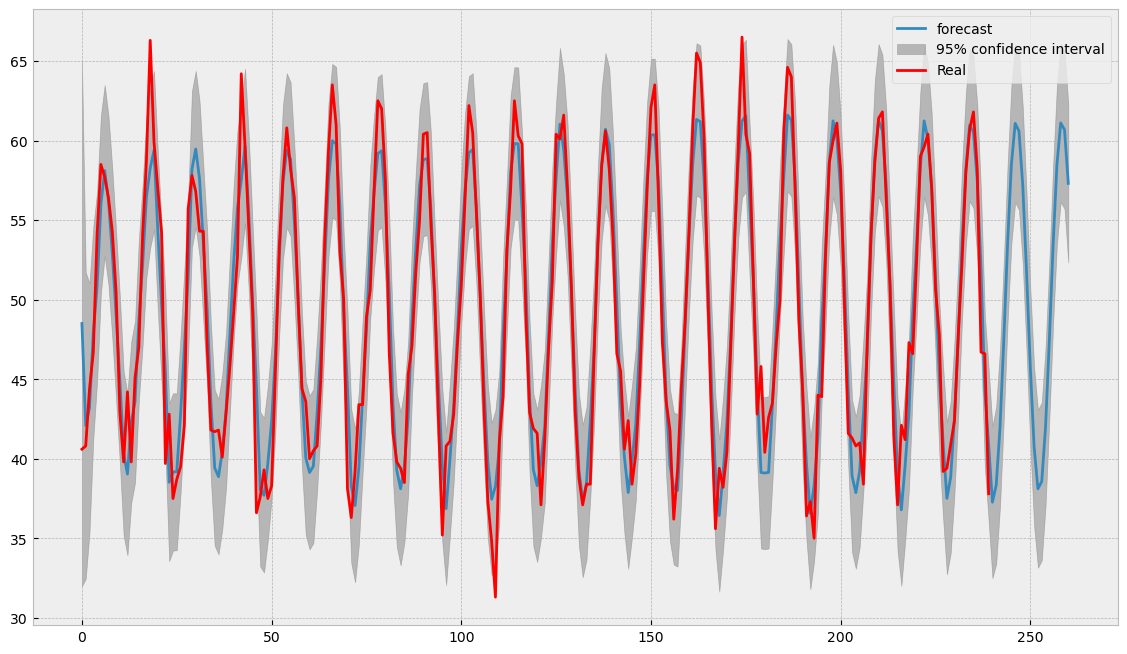

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(best_mdl, 0, len(mean_monthly_temp) + 20, ax=ax)
    plt.plot(mean_monthly_temp, color='red', label='Real')
    plt.legend()
    plt.show()

**Вывод:** Модель ARIMA смогла неплохо предсказать значения временного ряда Mean monthly air temperature (Deg. F) Nottingham Castle с ярковыраженной сезонностью.

### Спрогнозируем график классическим ML, используя библиотеку Skforecast

In [9]:
data = pd.read_csv('../Data/mean-monthly-air-temperature-deg.csv')
data.head()

,Month,Deg
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   240 non-null    object 
 1   Deg     240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


#### Разделение данных на train и test

Train dates : 0 --- 200  (n=201)
Test dates  : 200 --- 239  (n=40)


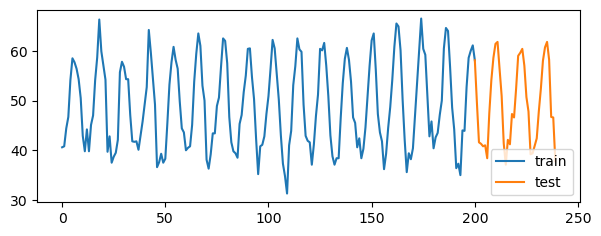

In [11]:
data_train = data[:-39]
data_test  = data[-40:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['Deg'].plot(ax=ax, label='train')
data_test['Deg'].plot(ax=ax, label='test')
ax.legend()
plt.show()

#### Подбор параметров модели

In [12]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=21), lags = 12)

steps = 40
param_grid = {'n_estimators': [50,100,150,200],
              'max_depth': [5, 7, 10]}

lags_grid = [9, 12]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Deg'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 7, 'n_estimators': 50}
  Backtesting metric: 7.09333281501876



In [13]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 7, 'n_estimators': 50}",7.093333,7,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",7.102694,10,50
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 50}",7.107062,5,50
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 200}",7.211100,5,200
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 7, 'n_estimators': 100}",7.231847,7,100
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",7.237783,10,100
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 150}",7.268227,5,150
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 150}",7.282873,10,150
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 200}",7.284336,10,200
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",7.315853,5,100


#### Обучение модели на основе подобранных параметров.

In [14]:
regressor = RandomForestRegressor(max_depth=7, n_estimators=50, random_state=21)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 12
             )

forecaster.fit(y=data_train['Deg'])

In [15]:
predictions = forecaster.predict(steps=40)

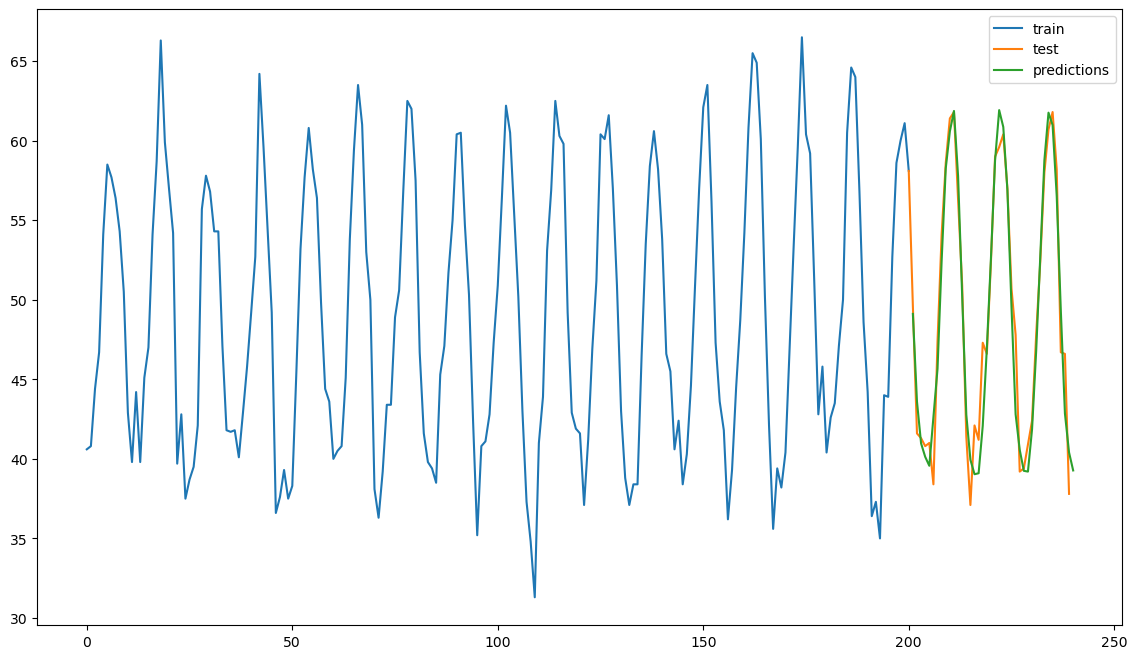

In [16]:
fig, ax = plt.subplots(figsize=(14, 8))
data_train['Deg'].plot(ax=ax, label='train')
data_test['Deg'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [17]:
error_mse = mean_squared_error(
                y_true = data_test['Deg'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 22.20942913596139


### Выводы:

Была построена модель ARIMA временного ряда и был дан прогноз.
Также был спрогнозирован график с помощью классического ML-подхода, используя библиотеку Skforecast и подобранные параметры для модели.
Обе модели показали достаточно неплохой результат предсказания.